# **PINN Optimizada**

### **Objetivo:** Implementar una arquitectura PINN con reanálisis de 500 hPa.

**Descripción:** Utilizando los reanálisis de 00, 06, 12 y 18Z, el modelo aprende a inferir el estado en el tiempo *t + 6 hs*, a partir de el estado en el tiempo *t*, y de las ecuaciones de pronóstico estacionarias en el tiempo *t + 6 hs.*

Además, el modelo aprende a inferir el estado *t + 12 hs* a partir de su inferencia previa del tiempo *t + 6 hs.* Esto permite que el modelo sea más estable en evoluciones a largo plazo.

El estado queda definido por las siguientes variables (el aprendizaje temporal queda implícito en el modelo).

**Variables:**
1. componente zonal del viento (u)
2. Componente meridional del viento (v)
3. temperatura (temp)
4. altura geopotencial (alt_geop)

**Entrada:** Datos de reanálisis. Corresponde al tiempo *t.*
- longitud, latitud, u, v, temperatura y altura geopotencial

**Salida:** Inferencias, correspondientes al tiempo *t + 6hs.*
- u, v, temperatura y altura geopotencial

**Función de pérdida (MSE):**
1. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 6 hs.*
2. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 12 hs.*
3. Pérdida por física, optimizando las ecuaciones de pronóstico estacionarias, utilizando las inferenicas, en el *t + 6 hs.*
4. Pérdida por física, optimizando las ecuaciones de pronóstico estacionarias, utilizando las inferenicas, en el *t + 12 hs.*

**Normalizaciones:**
- Variables físicas por media/desvío estándar (M=0, SD=1).
- Variables espaciales por mínimo/máximo [0, 1].

**Hiperparámetros del modelo:**
- Tres capas en total, una oculta con 12 neuronas.
- Función de activación: tangente hiperbólica. Dominio (-inf, inf). Rango (-1, 1).
- Learning rate:
  - *Cosine learning-rate schedule* de 0,0030 a 0,0001
- Épocas: 15
- Coeficientes de pérdidas: Datos: 1,000 y EDP: 0,015.

In [1]:
# Instala librerías necesarias
!apt-get install -y libeccodes-data libeccodes-dev
!pip install torch torchvision torchaudio scipy
!pip install basemap
!pip install basemap-data-hires

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerias necesarias
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from netCDF4 import Dataset
import os
import gc

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Definir y verificar el dispositvo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("¿PyTorch detecta CUDA?:", torch.cuda.is_available())
print("Versión de CUDA en PyTorch:", torch.version.cuda)
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ninguna")

¿PyTorch detecta CUDA?: True
Versión de CUDA en PyTorch: 12.1
GPU detectada: NVIDIA GeForce RTX 3060


In [4]:
# Define las rutas a los archivos
"""
1: Geopotential: m**2 s**-2 (instant): isobaricInhPa: level 500: fcst time 0 hrs
2: Temperature: K (instant): isobaricInhPa :level 500: fcst time 0 hrs
3: U component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs
4: V component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs

Continua con 06Z, 12Z y 18Z respestando el orden.
"""
ruta_notebook = os.getcwd()
ruta_dir_padre = os.path.dirname(ruta_notebook)
ruta_files = ruta_dir_padre + '/files/'

filename_train = ruta_files + '200401201501.nc'
filename_val = ruta_files + '201601.nc'

In [5]:
# Cargar datos desde GRIB
def load_nc_data(filename):
    # Abre el archivo
    ds = Dataset(filename, mode='r')
    #print(ds.variables)
    
    # Selecciona las variables de interés
    alt_geop = ds.variables['z'][:].squeeze()        # Altura del geopotencial [m^2*S^-2]
    u = ds.variables['u'][:].squeeze()               # Componente zonal del viento [m/s]
    v = ds.variables['v'][:].squeeze()               # Componente meridional del viento [m/s]
    temp = ds.variables['t'][:].squeeze()            # Temperatura [K]
    lat = ds.variables['latitude'][:]                # Latitud [º Norte]
    lon = ds.variables['longitude'][:]               # Longitud [º Este]

    # Crear la retícula de puntos equiespaciaods
    lons, lats = np.meshgrid(lon, lat)

    # Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud)
    alt_geop = np.array(alt_geop)
    temp = np.array(temp)
    u = np.array(u)
    v = np.array(v)
    lons = np.array(lons)
    lats = np.array(lats)

    # Calculo Parámetro de Coriolis
    f = 2*(7.292*(10**(-5)))*np.sin(np.radians(lats))      # [1/s]

    # Convertir latitud y longitud a coordenadas en metros
    R = 6371000  # Radio terrestre en metros
    lat0, lon0 = -60, -80  # Origen de coordenadas

    x = R * np.cos(np.radians(lat0)) * np.radians(lons - lon0)
    y = R * np.radians(lats - lat0)

    return f, x, y, u, v, temp, alt_geop

In [6]:
# Función para normalización Min-Max
def min_max_normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)

    if data_max == data_min:
        return np.zeros_like(data)  # Evita divisiones por cero en caso de valores constantes

    return (data - data_min) / (data_max - data_min)

In [7]:
# Función para normalización z-score de datos de entrenamiento
def z_score_train_normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    if std == 0:
        return np.zeros_like(data)  # Evita divisiones por cero si los datos son constantes

    return mean, std, (data - mean) / std

In [8]:
# Función para normalización z-score
def z_score_normalize(data, mean, std):

    return (data - mean) / std

In [9]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 12),  # Entrada en to: [x, y, u, v, temp, alt_geop] a capa oculta con 12 neuronas
            nn.Tanh(),
            nn.Linear(12, 4)   # Capa oculta a Salida: [u, v, temp, alt_geop] en to + Δt
        )

    def forward(self, x, y, u, v, temp, alt_geop):
        inputs = torch.cat([x, y, u, v, temp, alt_geop], dim=1)
        output = self.net(inputs)
        u_pred, v_pred, temp_pred, alt_geop_pred = output[:, 0:1], output[:, 1:2], output[:, 2:3], output[:, 3:4]

        return u_pred, v_pred, temp_pred, alt_geop_pred

In [10]:
# Definir la función de pérdida con la ecuación de energía
def edp_loss(f, X, Y, u_pred, v_pred, temp_pred, alt_geop_pred):

    # Calculo de derivadas parciales mediante Diferenciación Automática
    du_dx = torch.autograd.grad(u_pred, X, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]              # Derivada de u con respecto a x
    du_dy = torch.autograd.grad(u_pred, Y, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]              # Derivada de u con respecto a y
    dv_dx = torch.autograd.grad(v_pred, X, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]              # Derivada de v con respecto a x
    dv_dy = torch.autograd.grad(v_pred, Y, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]              # Derivada de v con respecto a y
    dtemp_dx = torch.autograd.grad(temp_pred, X, grad_outputs=torch.ones_like(temp_pred), create_graph=True)[0]     # Derivada de temp con respecto a x
    dtemp_dy = torch.autograd.grad(temp_pred, Y, grad_outputs=torch.ones_like(temp_pred), create_graph=True)[0]     # Derivada de temp con respecto a y
    dalt_geop_dx = torch.autograd.grad(alt_geop_pred, X, grad_outputs=torch.ones_like(alt_geop_pred), create_graph=True)[0]  # Derivada de alt_geop con respecto a x
    dalt_geop_dy = torch.autograd.grad(alt_geop_pred, Y, grad_outputs=torch.ones_like(alt_geop_pred), create_graph=True)[0]  # Derivada de alt_geop con respecto a y

    # Ecuación de continuidad: du/dx + dv/dy = 0 (considera fluido incompresible y flujo estacionario)
    loss_continuity = torch.mean((du_dx + dv_dy) ** 2)

    # Ecuación de energía: u * dT/dx + v * dT/dy = 0 (considera atmósfera adiabática y flujo estacionario)
    loss_energy = torch.mean((u_pred * dtemp_dx + v_pred * dtemp_dy) ** 2)

    # Momentum en x: u * du/dx + v * du/dy + dG/dx - f * v = 0 (considera fluido estacionario y aproximación hidrostática)
    loss_momentum_x = torch.mean((u_pred * du_dx + v_pred * du_dy + dalt_geop_dx - f * v_pred) ** 2)

    # Momentum en y: u * dv/dx + v * dv/dy + dG/dy + f * u = 0 (considera fluido estacionario y aproximación hidrostática)
    loss_momentum_y = torch.mean((u_pred * dv_dx + v_pred * dv_dy + dalt_geop_dy + f * u_pred) ** 2)

    # Pérdida total por EDP
    loss_fn = loss_energy + loss_continuity + loss_momentum_x + loss_momentum_y

    return loss_fn

In [11]:
# Función de pérdida de datos etiquetados (error cuadrático)
def label_loss(u_pred, v_pred, temp_pred, alt_geop_pred, u_data, v_data, temp_data, alt_geop_data):

    return torch.mean((u_pred - u_data)**2 + (v_pred - v_data)**2 + (temp_pred - temp_data)**2 + (alt_geop_pred - alt_geop_data)**2)

In [12]:
# Cargar datos de entrenamiento
"""
Dimensiones:

Variables físicas [tiempo, latitud, longitud]: (4*365, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
f, x, y, u_train, v_train, temp_train, alt_geop_train = load_nc_data(filename_train)

In [13]:
# Definir la cantidad total de reanálisis horarios
dims_train = u_train.shape
train_num_reanalysis_hours = dims_train[0]
print(f"Cantidad de reanálisis para entrenamiento disponibles: {train_num_reanalysis_hours}")

Cantidad de reanálisis para entrenamiento disponibles: 1488


In [14]:
# Cargar datos de validación
"""
Dimensiones:

Variables físicas [u, v, temperatura, altura geopotencial]: (4*31, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
*_, u_val, v_val, temp_val, alt_geop_val = load_nc_data(filename_val)

In [15]:
# Definir la cantidad total de reanálisis horarios
dims_val = u_val.shape
val_num_reanalysis_hours = dims_val[0]
print(f"Cantidad de reanálisis para validación disponibles: {val_num_reanalysis_hours}")

Cantidad de reanálisis para validación disponibles: 124


In [16]:
# Normalizar variables espaciales de entrada
x = min_max_normalize(x)
y = min_max_normalize(y)

In [17]:
# Tensorizar datos de entrada espacial
"""
Dimensiones de los Tensores: torch.Size([19481, 1]), debido a 161 x 121 = 19481
"""
x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

In [18]:
# Normalizar parámetro de coriolis
f = min_max_normalize(f)

In [19]:
# Tensorizar parámetro de coriolis
"""
Dimensiones de los Tensores: torch.Size([19481, 1]), debido a 161 x 121 = 19481
"""
f_tensor = torch.tensor(f.reshape(-1, 1), dtype=torch.float32)

In [20]:
# Separar los tiempos para armar los tensores de entrenamiento
def separate_time(ini, mid, fin, u, v, temp, alt_geop):
  """
  Separa los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  En todos los casos son en retículas de latitud/longitud.
  """
  u_ini, u_mid, u_fin = u[ini, :, :], u[mid, :, :], u[fin, :, :]
  v_ini, v_mid, v_fin = v[ini, :, :], v[mid, :, :], v[fin, :, :]
  temp_ini, temp_mid, temp_fin = temp[ini, :, :], temp[mid, :, :], temp[fin, :, :]
  alt_geop_ini, alt_geop_mid, alt_geop_fin = alt_geop[ini, :, :], alt_geop[mid, :, :], alt_geop[fin, :, :]

  return u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin

In [21]:
# Normalizar datos de entrenamiento
u_train_mean, u_train_std, u_norm_train = z_score_train_normalize(u_train)
v_train_mean, v_train_std, v_norm_train = z_score_train_normalize(v_train)
temp_train_mean, temp_train_std, temp_norm_train = z_score_train_normalize(temp_train)
alt_geop_train_mean, alt_geop_train_std, alt_geop_norm_train = z_score_train_normalize(alt_geop_train)

In [22]:
# Normalizar datos de validación
u_norm_val = z_score_normalize(u_val, u_train_mean, u_train_std)
v_norm_val = z_score_normalize(v_val, v_train_mean, v_train_std)
temp_norm_val = z_score_normalize(temp_val, temp_train_mean, temp_train_std)
alt_geop_norm_val = z_score_normalize(alt_geop_val, alt_geop_train_mean, alt_geop_train_std)

In [23]:
# Tensorizar los datos
def tensorize_data(u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin):
  """
  Tensorizar los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  """
  u_tensor_ini = torch.tensor(u_ini.reshape(-1, 1), dtype=torch.float32)
  v_tensor_ini = torch.tensor(v_ini.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_ini = torch.tensor(temp_ini.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_ini = torch.tensor(alt_geop_ini.reshape(-1, 1), dtype=torch.float32)
  u_tensor_mid = torch.tensor(u_mid.reshape(-1, 1), dtype=torch.float32)
  v_tensor_mid = torch.tensor(v_mid.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_mid = torch.tensor(temp_mid.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_mid = torch.tensor(alt_geop_mid.reshape(-1, 1), dtype=torch.float32)
  u_tensor_fin = torch.tensor(u_fin.reshape(-1, 1), dtype=torch.float32)
  v_tensor_fin = torch.tensor(v_fin.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_fin = torch.tensor(temp_fin.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_fin = torch.tensor(alt_geop_fin.reshape(-1, 1), dtype=torch.float32)

  return u_tensor_ini, v_tensor_ini, temp_tensor_ini, alt_geop_tensor_ini, u_tensor_mid, v_tensor_mid, temp_tensor_mid, alt_geop_tensor_mid, u_tensor_fin, v_tensor_fin, temp_tensor_fin, alt_geop_tensor_fin

In [24]:
# Inicializar modelo y optimizador
model = PINN()

In [25]:
print(model)

PINN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [26]:
# Mover el modelo a la GPU
model = model.to(device)

In [27]:
# Mover los tensores espaciales a la GPU
f_tensor = f_tensor.to(device)
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)

In [28]:
# Mover los tensores físicos a la GPU
def move_tensors(u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move, dispositivo=device):
    u_tensor_move = u_tensor_move.to(dispositivo)
    v_tensor_move = v_tensor_move.to(dispositivo)
    temp_tensor_move = temp_tensor_move.to(dispositivo)
    alt_geop_tensor_move = alt_geop_tensor_move.to(dispositivo)

    return u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move

In [29]:
# Almacenar las pérdidas para graficar
train_losses_avg = []
train_losses_edp_avg = []
train_losses_data_avg = []
val_losses_avg = []
val_losses_edp_avg = []
val_losses_data_avg = []

In [30]:
# Hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 15

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00010)

# Número de rentrenamientos en train
num_retrains_train = train_num_reanalysis_hours - 2

# Número de rentrenamientos en val
num_retrains_val = val_num_reanalysis_hours - 2

In [31]:
# Pesos componentes de pérdida
lambda_datos = 1.000
lambda_edp = 0.015 

In [32]:
# Entrenamiento con Rollout en Dos Pasos
for epoch in range(epochs):

  # Inicializa el primer reanálisis de inicio, intermedio y de fin
  ini_train = 0
  mid_train = 1
  fin_train = 2
  ini_val = 0
  mid_val = 1
  fin_val = 2

  # Inicializa la pérdida total de la época
  total_train_loss = 0.0
  total_train_loss_edp = 0.0
  total_train_loss_data = 0.0
  total_val_loss = 0.0
  total_val_loss_edp = 0.0
  total_val_loss_data = 0.0

  # ENTRENAMIENTO
  # Recorriendo los reanálisis
  for retrain in range(num_retrains_train):

    optimizer.zero_grad()

    # Separar tiempos de datos etiquetados
    u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
    # Tensorizar datos etiquetados
    u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

    # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
    u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
    u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
    u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

    # Habilitar la diferenciación automática variables espaciales
    x_tensor.requires_grad_(True)
    y_tensor.requires_grad_(True)
    # Habilitar la diferenciación automática variable físicas
    u_tensor_ini_train.requires_grad_(True)
    v_tensor_ini_train.requires_grad_(True)
    temp_tensor_ini_train.requires_grad_(True)
    alt_geop_tensor_ini_train.requires_grad_(True)
    u_tensor_mid_train.requires_grad_(True)
    v_tensor_mid_train.requires_grad_(True)
    temp_tensor_mid_train.requires_grad_(True)
    alt_geop_tensor_mid_train.requires_grad_(True)

    # Primera predicción del modelo sobre datos de entrenamiento
    u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(x_tensor, y_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

    # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
    u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

    # Segunda predicción del modelo sobre datos de entrenamiento
    u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(x_tensor, y_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

    # Mover los tensores (t=12), usados durante el entrenamiento, a device
    u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

    # Cálculo de pérdidas datos etiquetados
    loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
    loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
    train_loss_data = loss_ini_mid_datos_train + loss_mid_fin_datos_train

    # Cálculo de pérdidas por ecuaciones diferenciales
    loss_ini_mid_edp_train = edp_loss(f_tensor, x_tensor, y_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)
    loss_mid_fin_edp_train = edp_loss(f_tensor, x_tensor, y_tensor, u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)
    train_loss_edp = loss_ini_mid_edp_train + loss_mid_fin_edp_train

    # Pérdida total combinada
    train_loss = lambda_datos*train_loss_data + lambda_edp*train_loss_edp

    # Retropropagación
    train_loss.backward()
    optimizer.step()
    total_train_loss += train_loss.item()
    total_train_loss_edp += train_loss_edp.item()
    total_train_loss_data += train_loss_data.item()

    # Cambiar los siguientes reanálisis consecutivos
    ini_train += 1
    mid_train += 1
    fin_train += 1

  # VALIDACIÓN
  for retrain_val in range(num_retrains_val):

    # Separar tiempos de datos etiquetados de validación
    u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
    # Tensorizar datos etiquetados de validación
    u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

    # Mover los tensores (t=0) de entrada, usados durante la validación, a device
    u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
    u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
    u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

    # Primera predicción del modelo sobre datos de validación
    u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(x_tensor, y_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

    # Mover los tensores (t=6) de entrada, usados durante la validación, a device
    u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

    # Segunda predicción del modelo sobre datos de validación
    u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(x_tensor, y_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

    # Mover los tensores (t=12) de entrada, usados durante la validación, a device
    u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

    # Cálculo de pérdidas datos etiquetados de validación
    loss_ini_mid_datos_val = label_loss(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
    loss_mid_fin_datos_val = label_loss(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
    val_loss_data = loss_ini_mid_datos_val + loss_mid_fin_datos_val

    # Cálculo de pérdidas por ecuaciones diferenciales en validación
    loss_ini_mid_edp_val = edp_loss(f_tensor, x_tensor, y_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)
    loss_mid_fin_edp_val = edp_loss(f_tensor, x_tensor, y_tensor, u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)
    val_loss_edp = loss_ini_mid_edp_val + loss_mid_fin_edp_val

    # Pérdida total combinada en validación
    val_loss = lambda_datos*val_loss_data + lambda_edp*val_loss_edp

    # Acumulación de pérdida por época
    total_val_loss += val_loss.item()
    total_val_loss_edp += val_loss_edp.item()
    total_val_loss_data += val_loss_data.item()

    # Cambiar los siguientes reanálisis consecutivos
    ini_val += 1
    mid_val += 1
    fin_val += 1

  # Actualizar el learning rate con el scheduler
  scheduler.step()

  # Calcular las pérdidas medias de entrenamiento
  avg_train_loss = total_train_loss / train_num_reanalysis_hours
  avg_train_loss_edp = total_train_loss_edp / train_num_reanalysis_hours
  avg_train_loss_data = total_train_loss_data / train_num_reanalysis_hours
  # Guardar pérdidas medias de entrenamiento para gráficas
  train_losses_avg.append(avg_train_loss)
  train_losses_edp_avg.append(avg_train_loss_edp)
  train_losses_data_avg.append(avg_train_loss_data)
  # Calcular las pérdidas medias de validación
  avg_val_loss = total_val_loss / val_num_reanalysis_hours
  avg_val_loss_edp = total_val_loss_edp / val_num_reanalysis_hours
  avg_val_loss_data = total_val_loss_data / val_num_reanalysis_hours
  # Guardar pérdidas medias de validación para gráficas
  val_losses_avg.append(avg_val_loss)
  val_losses_edp_avg.append(avg_val_loss_edp)
  val_losses_data_avg.append(avg_val_loss_data)

  if epoch % 1 == 0:
      print(f"Epoch {epoch}, Average Train Loss: {avg_train_loss:.2f}, Average Validation Loss: {avg_val_loss:.2f}")

Epoch 0, Average Train Loss: 1.87, Average Validation Loss: 1.72
Epoch 1, Average Train Loss: 1.62, Average Validation Loss: 1.69
Epoch 2, Average Train Loss: 1.59, Average Validation Loss: 1.67
Epoch 3, Average Train Loss: 1.58, Average Validation Loss: 1.66
Epoch 4, Average Train Loss: 1.56, Average Validation Loss: 1.65
Epoch 5, Average Train Loss: 1.55, Average Validation Loss: 1.64
Epoch 6, Average Train Loss: 1.53, Average Validation Loss: 1.62
Epoch 7, Average Train Loss: 1.52, Average Validation Loss: 1.59
Epoch 8, Average Train Loss: 1.50, Average Validation Loss: 1.56
Epoch 9, Average Train Loss: 1.49, Average Validation Loss: 1.53
Epoch 10, Average Train Loss: 1.48, Average Validation Loss: 1.49
Epoch 11, Average Train Loss: 1.47, Average Validation Loss: 1.47
Epoch 12, Average Train Loss: 1.46, Average Validation Loss: 1.45
Epoch 13, Average Train Loss: 1.46, Average Validation Loss: 1.45
Epoch 14, Average Train Loss: 1.45, Average Validation Loss: 1.45


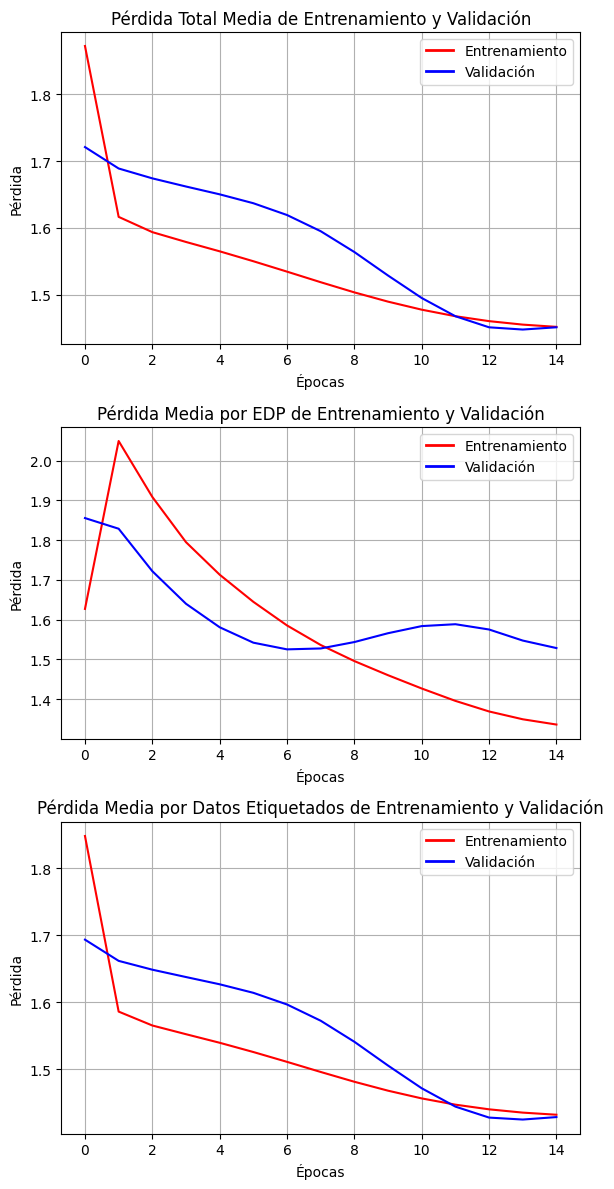

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))  # 3 filas, 1 columna

# Colores y leyenda común
colors = ['red', 'blue']
labels = ['Entrenamiento', 'Validación']
custom_lines = [
    Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
    Line2D([0], [0], color=colors[1], lw=2, label=labels[1])
]

# 1. Pérdida Total
axs[0].plot(range(epochs), train_losses_avg, color=colors[0])
axs[0].plot(range(epochs), val_losses_avg, color=colors[1])
axs[0].set_title('Pérdida Total Media de Entrenamiento y Validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].grid(True)
axs[0].legend(handles=custom_lines)

# 2. Pérdida por PDE
axs[1].plot(range(epochs), train_losses_edp_avg, color=colors[0])
axs[1].plot(range(epochs), val_losses_edp_avg, color=colors[1])
axs[1].set_title('Pérdida Media por EDP de Entrenamiento y Validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Pérdida')
axs[1].grid(True)
axs[1].legend(handles=custom_lines)

# 3. Pérdida por datos etiquetados
axs[2].plot(range(epochs), train_losses_data_avg, color=colors[0])
axs[2].plot(range(epochs), val_losses_data_avg, color=colors[1])
axs[2].set_title('Pérdida Media por Datos Etiquetados de Entrenamiento y Validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('Pérdida')
axs[2].grid(True)
axs[2].legend(handles=custom_lines)

plt.tight_layout()
plt.show()

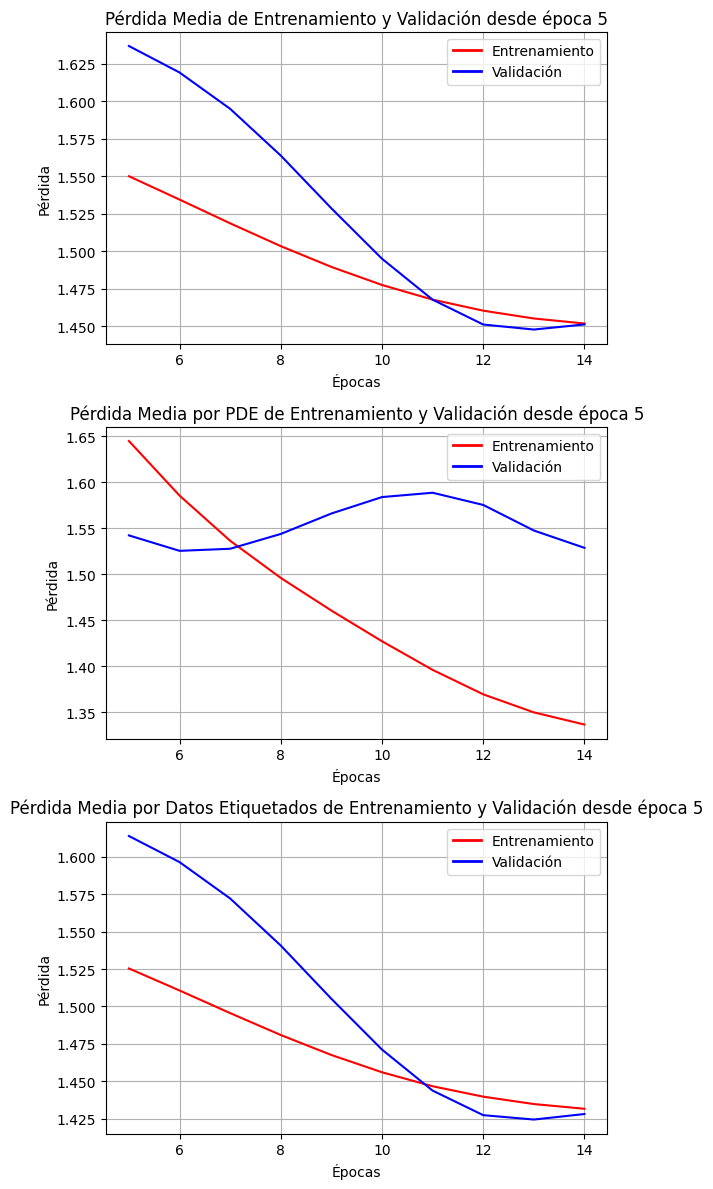

In [34]:
# Epoch desde la cual empezar
start_epoch = 5

# Crear figura con 3 subplots verticales
fig, axs = plt.subplots(3, 1, figsize=(6, 12))  # 3 filas, 1 columna

# Colores y leyenda común
colors = ['red', 'blue']
labels = ['Entrenamiento', 'Validación']
custom_lines = [
    Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
    Line2D([0], [0], color=colors[1], lw=2, label=labels[1])
]

# 1. Pérdida Total
axs[0].plot(range(start_epoch, epochs), train_losses_avg[start_epoch:], color=colors[0])
axs[0].plot(range(start_epoch, epochs), val_losses_avg[start_epoch:], color=colors[1])
axs[0].set_title(f'Pérdida Media de Entrenamiento y Validación desde época {start_epoch}')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].grid(True)
axs[0].legend(handles=custom_lines)

# 2. Pérdida por PDE
axs[1].plot(range(start_epoch, epochs), train_losses_edp_avg[start_epoch:], color=colors[0])
axs[1].plot(range(start_epoch, epochs), val_losses_edp_avg[start_epoch:], color=colors[1])
axs[1].set_title(f'Pérdida Media por PDE de Entrenamiento y Validación desde época {start_epoch}')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Pérdida')
axs[1].grid(True)
axs[1].legend(handles=custom_lines)

# 3. Pérdida por datos etiquetados
axs[2].plot(range(start_epoch, epochs), train_losses_data_avg[start_epoch:], color=colors[0])
axs[2].plot(range(start_epoch, epochs), val_losses_data_avg[start_epoch:], color=colors[1])
axs[2].set_title(f'Pérdida Media por Datos Etiquetados de Entrenamiento y Validación desde época {start_epoch}')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('Pérdida')
axs[2].grid(True)
axs[2].legend(handles=custom_lines)

plt.tight_layout()
plt.show()

In [35]:
# Ruta del archivo donde se guardará el modelo
model_path = ruta_dir_padre + '/Artefactos/modelo_PINN.pth'

# Guardar el modelo (state_dict)
torch.save(model.state_dict(), model_path)

print(f"Modelo guardado en: {model_path}")

Modelo guardado en: c:\Users\fabri\Documents\Posgrado\TRABAJO_FINAL\Modelos/Artefactos/modelo_PINN.pth
